In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [2]:
sns.set_style(style='white') 
sns.set(rc={
    'figure.figsize':(12,7), 
    'axes.facecolor': 'white',
    'axes.grid': True, 
    'grid.color': '.9',
    'axes.linewidth': 1.0,
    'grid.linestyle': u'-'},font_scale=1.5)

In [3]:
DATA_DIR = ''

train_data = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test_data = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

data = pd.concat([train_data, test_data], ignore_index=True, sort=False)

In [4]:
data.shape

(1309, 12)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


Поиск пропущенных значений
--

Так как общее количество строк — 1309, то мы явно видим наличие пропусков в данных.

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

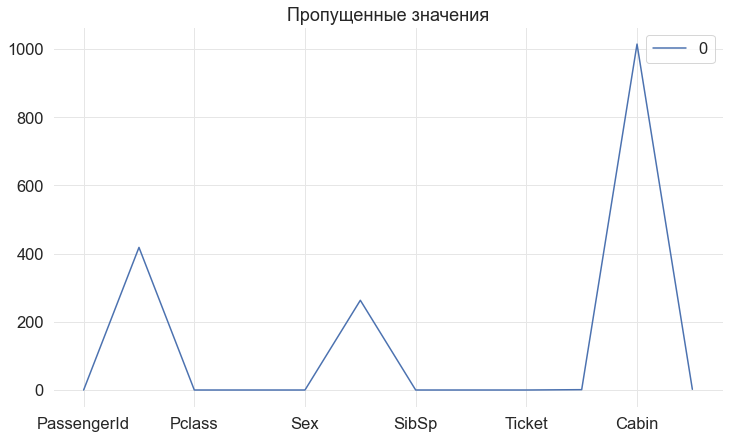

In [6]:
pd.DataFrame(data.isnull().sum()).plot.line().set_title("Пропущенные значения")
data.isnull().sum()

Столбцы с пропущенными данными:
--
- Survived
- Age
- Fare
- Cabin
- Embarked

1. Значения в столбце **Cabin** можно игнорировать, так как оно отсутствует почти на всей выборке данных
2. Пропущенные значения из колонки **Age** можно спрогнозировать на основе имени

Text(0.5, 1.0, 'Пропущенные значения — heatmap')

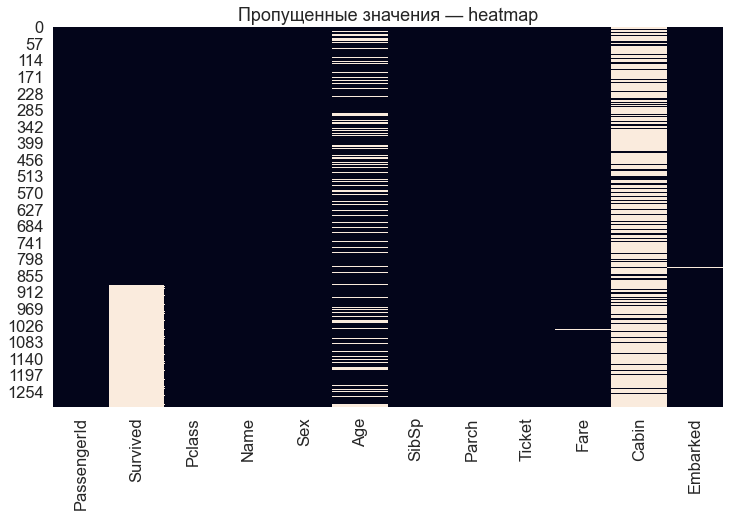

In [7]:
sns.heatmap(data.isnull(), cbar = False).set_title("Пропущенные значения — heatmap")

Получение уникальности данных
--
- **Survived** имеет 2 уникальных значения
- **Sex** имеет 2 уникальных значения
- **Pclass** имеет 3 уникальных значения
- **Embarked** имеет 3 уникальных значения

In [8]:
data.nunique()

PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
dtype: int64

Survived
--
Более 60% всех пассажиров погибло

Text(0.5, 1.0, 'Тренировочный набор — процент выживших и не выживших')

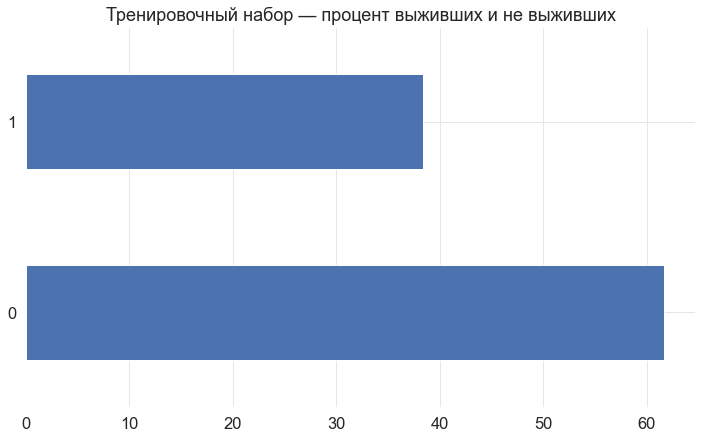

In [9]:
survived_percent = train_data.Survived.value_counts(normalize=True) * 100
survived_percent.plot.barh().set_title("Тренировочный набор — процент выживших и не выживших")

Pclass
--


<AxesSubplot:ylabel='Pclass'>

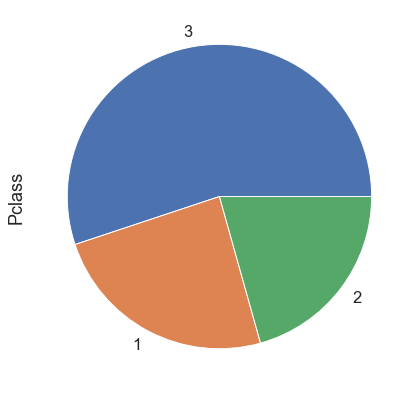

In [10]:
pclass_info = train_data.Pclass.value_counts()
pclass_info.plot.pie()

In [11]:
def get_percent_survivor_pclass(pclass: int):
    return round(
        (train_data[train_data.Pclass == pclass].Survived == 1).value_counts()[1] / len(train_data[train_data.Pclass == pclass]) * 100, 2
    )

pclass_1_survivor_distribution = get_percent_survivor_pclass(1)
pclass_2_survivor_distribution = get_percent_survivor_pclass(2)
pclass_3_survivor_distribution = get_percent_survivor_pclass(3)

Text(0.5, 1.0, 'Тренировочный набор - процент выживших/не выживших от класса на борту')

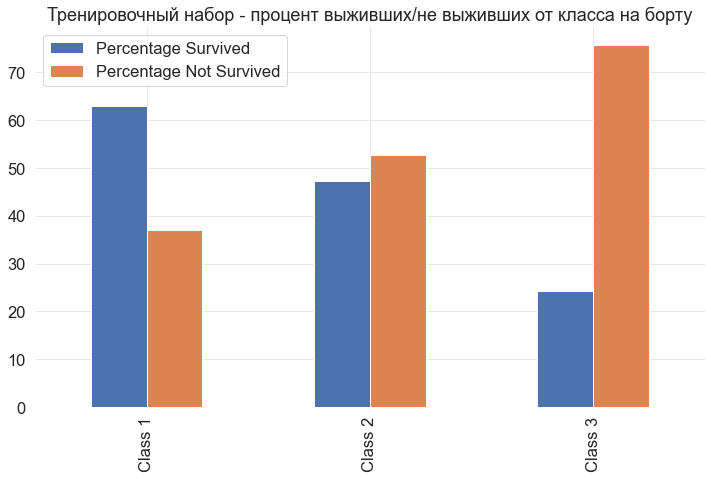

In [12]:
pclass_perc_df = pd.DataFrame({
    "Percentage Survived": {
        "Class 1": pclass_1_survivor_distribution,
        "Class 2": pclass_2_survivor_distribution, 
        "Class 3": pclass_3_survivor_distribution,
    },
    "Percentage Not Survived":{
        "Class 1": 100 - pclass_1_survivor_distribution,
        "Class 2": 100 - pclass_2_survivor_distribution, 
        "Class 3": 100 - pclass_3_survivor_distribution,
    }
})

pclass_perc_df.plot.bar().set_title("Тренировочный набор - процент выживших/не выживших от класса на борту")

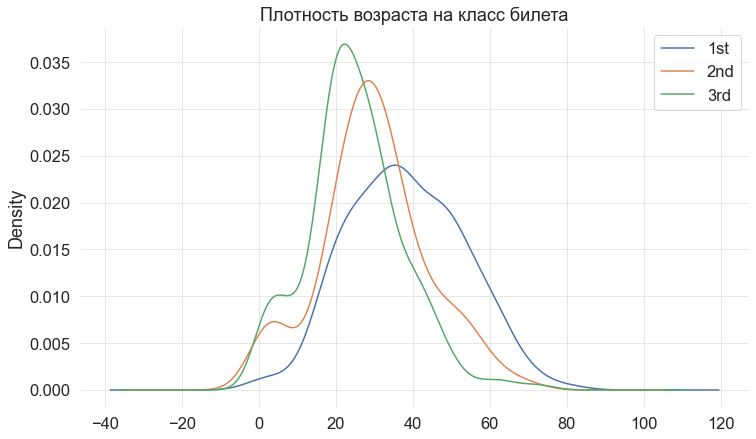

In [13]:
for pcl in (1, 2, 3):
    train_data.Age[train_data.Pclass == pcl].plot(kind="kde")

plt.title("Плотность возраста на класс билета")
plt.legend(("1st","2nd","3rd"))

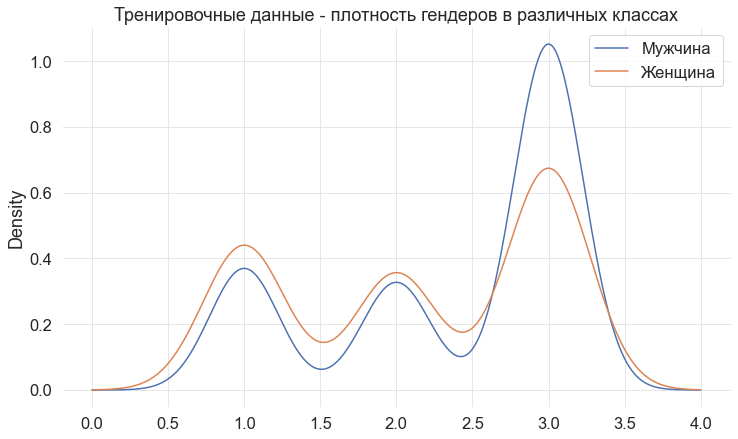

In [14]:
for x in ("male","female"):
    train_data.Pclass[train_data.Sex == x].plot(kind="kde")

plt.title("Тренировочные данные - плотность гендеров в различных классах")
plt.legend(("Мужчина","Женщина"))

In [15]:
pclass_perc_df

,Percentage Survived,Percentage Not Survived
Class 1,62.96,37.04
Class 2,47.28,52.72
Class 3,24.24,75.76


Соотношение полов
--
На корабле было более 65% мужчин. Остальные — женщины. Однако процент выживших среди женщин — выше. 

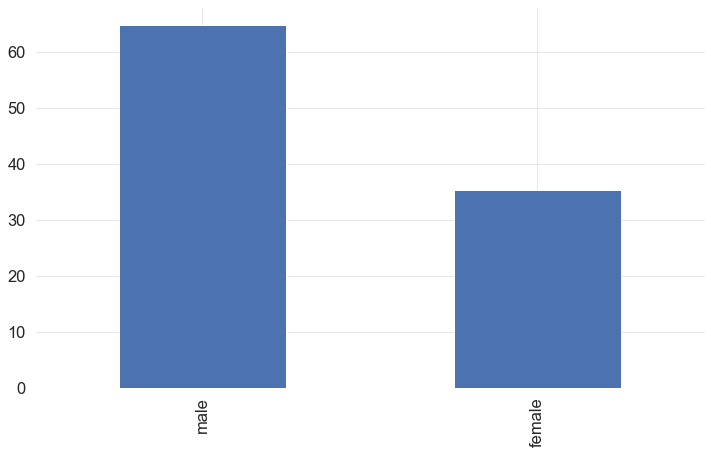

In [16]:
fig_sex = (train_data.Sex.value_counts(normalize = True) * 100).plot.bar()

Text(0.5, 1.0, 'Процент выживших и не выживших среди мужчин и женщин')

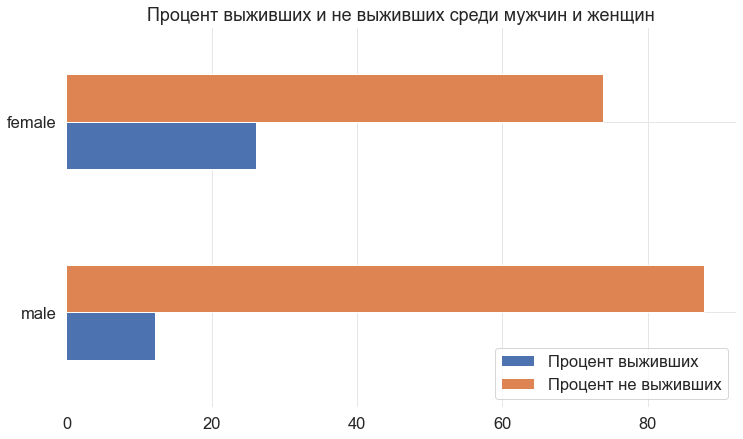

In [17]:
male_percent = round((train_data[train_data.Sex == 'male'].Survived == 1).value_counts()[1] / len(train_data.Sex) * 100, 2)
female_percent = round((train_data[train_data.Sex == 'female'].Survived == 1).value_counts()[1] / len(train_data.Sex) * 100, 2)

sex_perc_df = pd.DataFrame({
    "Процент выживших": {
        "male": male_percent, "female": female_percent
    },  
    "Процент не выживших": { 
        "male": 100 - male_percent, "female": 100 - female_percent
    }
})
sex_perc_df.plot.barh().set_title("Процент выживших и не выживших среди мужчин и женщин")

Возраст
--
Из описание столбца мы можем понять:
- Самому младшему 4 месяца
- Самому старшему 80 лет
- Средний возраст пассажиров — чуть меньше 30 лет

In [18]:
pd.DataFrame(train_data.Age.describe())

,Age
count,714.000000
mean,29.699118
std,14.526497
min,0.420000
25%,20.125000
50%,28.000000
75%,38.000000
max,80.000000


Из графика ниже можно понять
--
- Детей до 10 лет спаслось больше, чем погибло
- Количество умерших в возрасте (10, 80] всегда превышало количество выживших

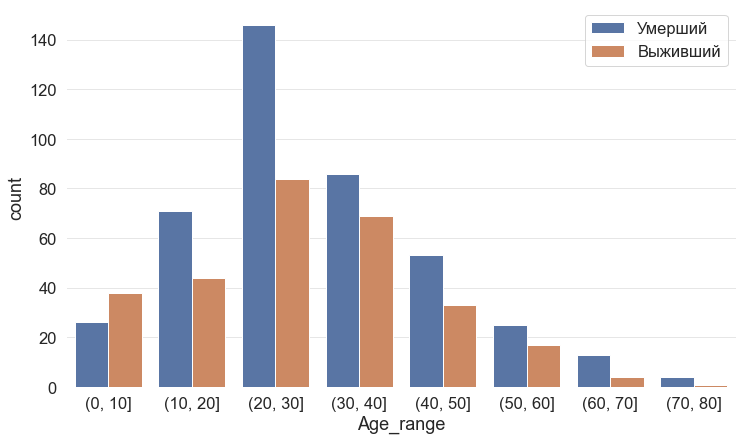

In [19]:
data['Age_range'] = pd.cut(data.Age, list(range(0, 90, 10)))
sns.countplot(x="Age_range", hue="Survived", data=data).legend(labels=["Умерший", "Выживший"])

<AxesSubplot:xlabel='Age', ylabel='Count'>

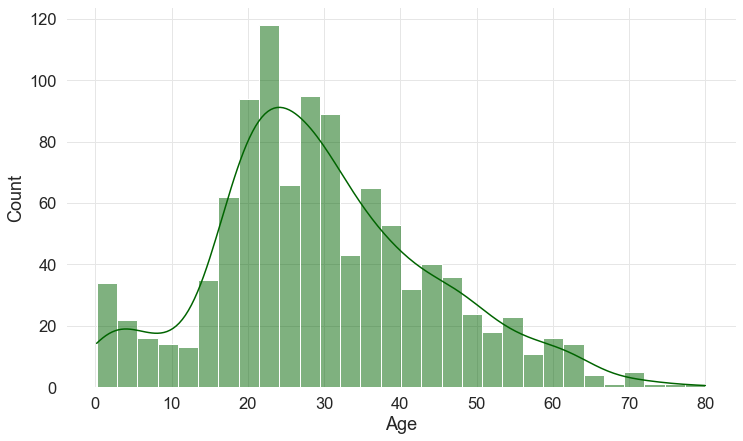

In [20]:
sns.histplot(data["Age"].dropna(), color="darkgreen", bins=30, kde=True)

Братья, сестры, супруги
--
В данном наборе родственников на борту не может превышать 8 человек. Чем меньше у человека родственников на борту, тем выше его шансы выжить

In [21]:
data.SibSp.describe()

count    1309.000000
mean        0.498854
std         1.041658
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         8.000000
Name: SibSp, dtype: float64

Выживаемость в зависимости от наличия родственников на борту
--
Из графика ниже становится ясно, что шансы на выживание при наличии более 2 родственников сильно снижаются

<AxesSubplot:>

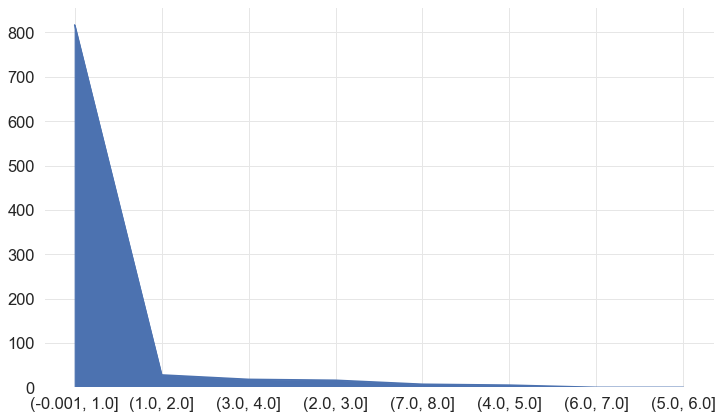

In [22]:
ss = pd.DataFrame({
    "survived": train_data.Survived,
    "sibling_spouse": pd.cut(train_data.SibSp, list(range(9)), include_lowest=True)
})
ss.sibling_spouse.value_counts().plot.area()

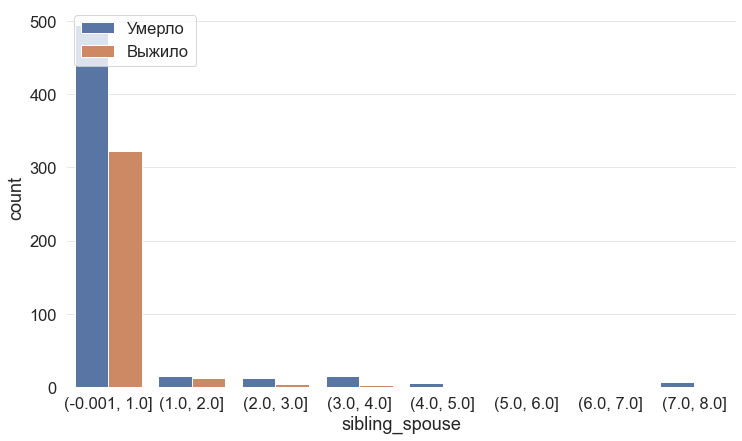

In [23]:
sns.countplot(x="sibling_spouse", hue="survived", data=ss).legend(labels=["Умерло", "Выжило"])

Родители и дети
--
Максимальное количество родителей/детей путешествовали вместе с пассажиром — 9. Люди, которые путешествовали в одиночку больше шансов на выживание.

In [24]:
pd.DataFrame(data.Parch.describe())

,Parch
count,1309.000000
mean,0.385027
std,0.865560
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,9.000000


<AxesSubplot:>

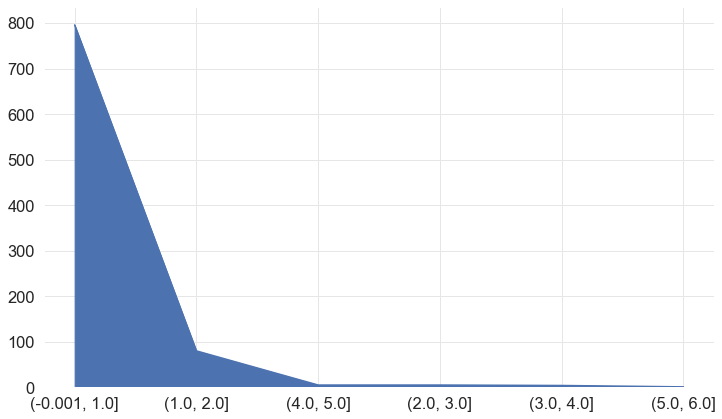

In [25]:
pc = pd.DataFrame({
    "survived": train_data.Survived,
    "parents_children": pd.cut(train_data.Parch, list(range(7)), include_lowest = True)
})
pc.parents_children.value_counts().plot.area()

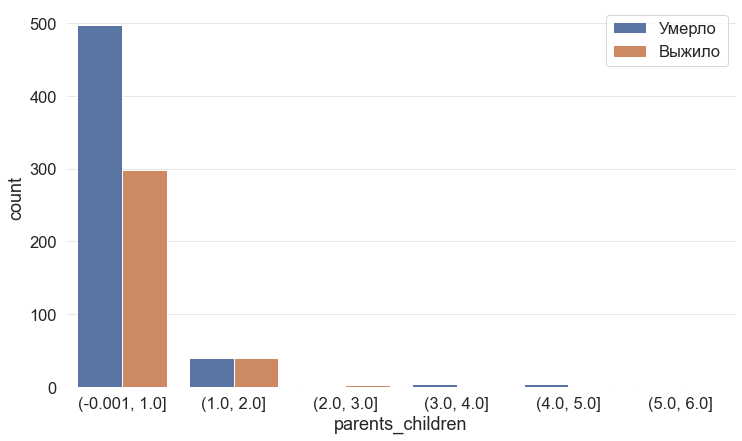

In [26]:
sns.countplot(x="parents_children", hue="survived", data=pc).legend(labels=["Умерло", "Выжило"])

In [27]:
data['Family'] = data.Parch + data.SibSp
data['Is_Alone'] = data.Family == 0

Цена за билет
--

Существует сильная корреляция между выжившими и ценой за билет.

In [28]:
data.Fare.describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [29]:
data['Fare_Category'] = pd.cut(data['Fare'], bins=[0, 7.90, 14.45, 31.28, 120], labels=['Low', 'Mid', 'High_Mid', 'High'])

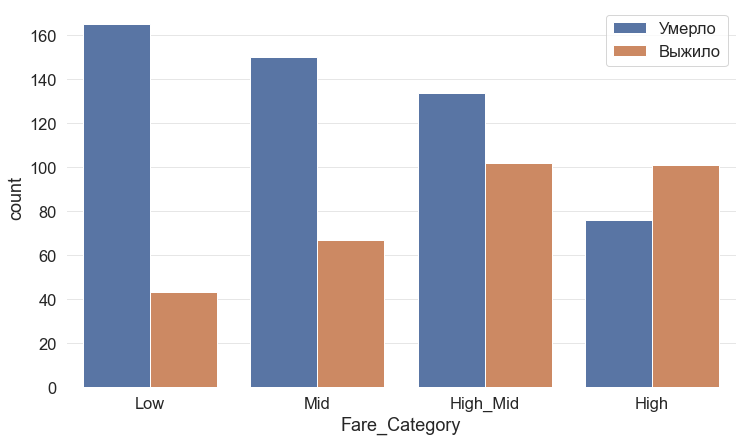

In [30]:
sns.countplot(x="Fare_Category", hue="Survived", data=data).legend(labels = ["Умерло", "Выжило"])

Место начала путешествия
--

Есть три возможных значения, где мог начать путшествие человек: Southampton, Cherbourg, Queenstown

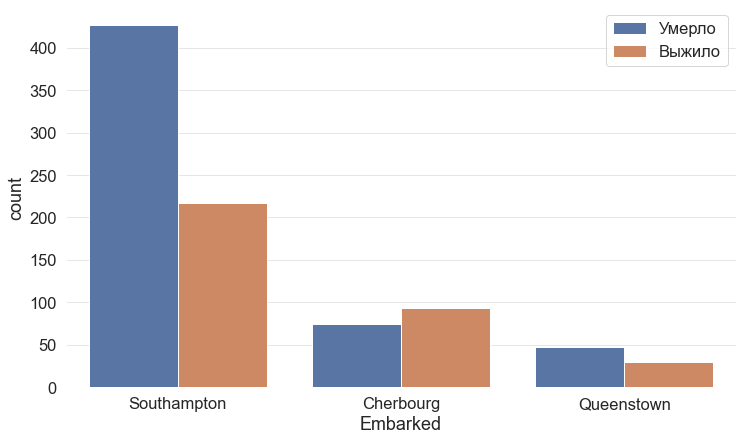

In [31]:
s = sns.countplot(x="Embarked", hue="Survived", data=train_data)
s.set_xticklabels(["Southampton","Cherbourg","Queenstown"])
s.legend(labels = ["Умерло", "Выжило"])

Заполнение пропушенных данных
-

In [32]:
data.isnull().sum()

PassengerId         0
Survived          418
Pclass              0
Name                0
Sex                 0
Age               263
SibSp               0
Parch               0
Ticket              0
Fare                1
Cabin            1014
Embarked            2
Age_range         263
Family              0
Is_Alone            0
Fare_Category      85
dtype: int64

Embarked
--

В Embarked отсутствует 2 значения. Так как приоритет по количеству за Southampton, то заполним данные им

In [33]:
data.Embarked.fillna(data.Embarked.mode()[0], inplace=True)

Age
--

Возраст имеет 263 пропущенных значения. Чтобы справиться с отсутствующими значениями, мы сначала пытаемся классифицировать людей по их титулам (mrs, miss ..). 
В данных обучения есть 17 различных названий. Мы группируем заголовки и пол, а затем находим медианное значение всех категорий и заменяем отсутствующие значения на медианное значение этой категории.

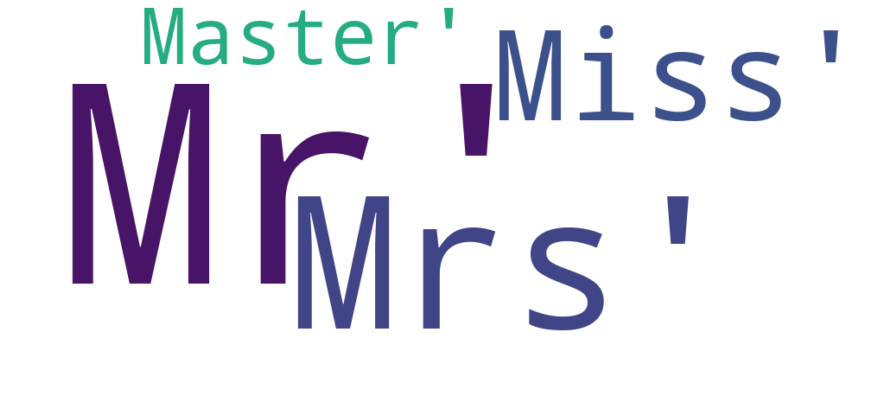

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Ms                2
Major             2
Capt              1
Don               1
the Countess      1
Dona              1
Lady              1
Sir               1
Jonkheer          1
Mme               1
Name: Salutation, dtype: int64

In [34]:
data['Salutation'] = data.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip()) 

data.Salutation.nunique()

wc = WordCloud(width=1000, height=450, background_color='white').generate(str(data.Salutation.values))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

data.Salutation.value_counts()

In [35]:
data.Age = data.groupby(['Sex', 'Pclass']).Age.apply(lambda x: x.fillna(x.median()))
data.Age.fillna(data.Age.median, inplace=True)

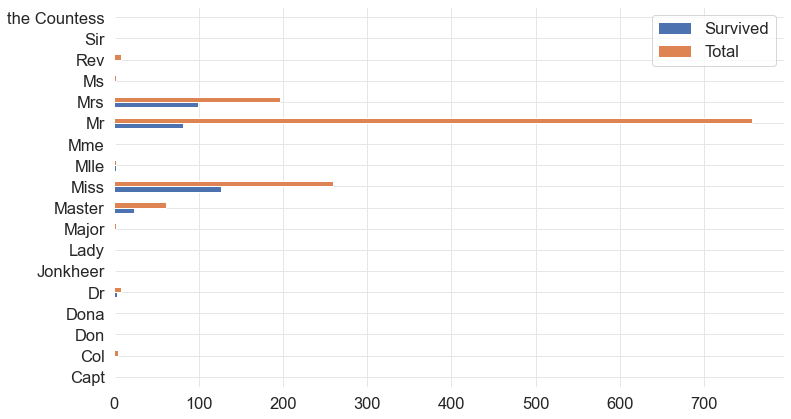

In [36]:
sal_df = pd.DataFrame({
    "Survived": data[data.Survived == 1].Salutation.value_counts(),
    "Total": data.Salutation.value_counts()
})
s = sal_df.plot.barh()


In [37]:
data.Cabin = data.Cabin.fillna('NA')

In [38]:
data = pd.concat([
    data, 
    pd.get_dummies(data.Cabin, prefix="Cabin"), 
    pd.get_dummies(data.Age_range, prefix="Age_range"), 
    pd.get_dummies(data.Embarked, prefix="Emb", drop_first = True), 
    pd.get_dummies(data.Salutation, prefix="Title", drop_first = True),
    pd.get_dummies(data.Fare_Category, prefix="Fare", drop_first = True), 
    pd.get_dummies(data.Pclass, prefix="Class", drop_first = True)
], axis=1)

data['Sex'] = LabelEncoder().fit_transform(data['Sex'])
data['Is_Alone'] = LabelEncoder().fit_transform(data['Is_Alone'])

data.drop(['Pclass', 'Fare', 'Cabin', 'Fare_Category', 'Name', 'Salutation', 'Ticket','Embarked', 'Age_range', 'SibSp', 'Parch', 'Age'], axis=1, inplace=True)

Прогнозирование
--
- Алгоритм для прогноза — случайный лес из решающих бинарных деревьев

In [44]:
X_to_be_predicted = data[data.Survived.isnull()]
X_to_be_predicted = X_to_be_predicted.drop(['Survived'], axis = 1)

train_data = data
train_data = train_data.dropna()
feature_train = train_data['Survived']
label_train  = train_data.drop(['Survived'], axis = 1)
train_data.shape

(891, 224)

In [ ]:
clf = GaussianNB()
x_train, x_test, y_train, y_test = train_test_split(label_train, feature_train, test_size=0.2)
clf.fit(x_train,  np.ravel(y_train))

print("NB Accuracy: " + repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")

NB Accuracy: 62.57%
